GA (Base)

gen	nevals	min   	avg   
0  	100   	350660	573750
1  	84    	200610	398266
2  	90    	100420	271948
3  	70    	71880 	149516
4  	88    	50720 	111139
5  	85    	40400 	94630.9
6  	82    	30720 	93640.7
7  	78    	20300 	60615.5
8  	90    	20300 	58094.2
9  	80    	20300 	44159.7
10 	88    	20300 	42438.3
11 	86    	20300 	52635.7
12 	82    	20300 	47106.1
13 	93    	20300 	55189.3
14 	81    	10350 	44043.4
15 	85    	300   	38743.5
16 	84    	300   	30758.1
17 	83    	300   	26673.8
18 	84    	300   	25864  
19 	84    	300   	26538  
20 	88    	300   	30568.3
21 	86    	300   	19075.4
22 	88    	300   	32773.1
23 	88    	300   	21523.5
24 	85    	300   	30244.9
25 	75    	300   	23356.2
26 	84    	300   	22127.8
27 	94    	300   	38173.6
28 	80    	300   	22637.7
29 	85    	300   	25245.1
30 	80    	300   	16536.9
31 	78    	300   	19942.4
32 	87    	300   	16328.3
33 	83    	300   	25721.8
34 	72    	300   	17817.8
35 	85    	300   	21541.7
36 	80    	300   	28652.9
37 	80    	300   	

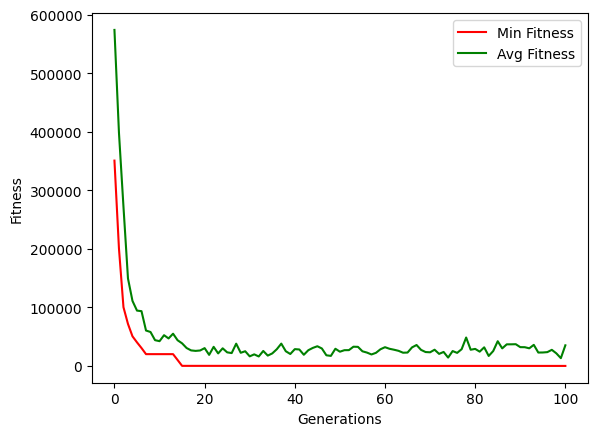

Schedule for each intake and programme:

Programme: SE
  Intake Jan: ST, MSDP, RMCE | RMCP
  Intake Mar: IA, OOSSE
  Intake Jun: NDP, SESE, RMCE | RMCP, RM
  Intake Aug: MSDP, DM, IA, ST
  Intake Oct: SQE, OOSSE, RMCE | RMCP, NDP

Programme: DSBA
  Intake Jan: TSF | DL, AML, RMCE | RMCP
  Intake Mar: MMDA, DAP, ABAV
  Intake Jun: RMCE | RMCP, BIS, SEM | DPM
  Intake Aug: MMDA, DM, TSF | DL, AML
  Intake Oct: RMCE | RMCP, DAP, BSSMMA | CIS

Violations Summary:
Consecutive module intake violations: 0
RMCE module intake violations: 0
Concurrent module violations: 0
SE student constraint violations: 3

Violations by Student:
Student ABC0074: 1 violations
Student ABC0110: 1 violations
Student ABC0503: 1 violations

SE Student Suggestions:
ABC0013: ['-', '-', '-', '-', '-']
ABC0074: ['RMCE | RMCP', 'OOSSE', 'RM', 'MSDP', '-']
ABC0099: ['-', '-', '-', '-', '-']
ABC0106: ['-', '-', '-', '-', '-']
ABC0109: ['RMCE | RMCP', 'OOSSE', 'RM', '-', '-']
ABC0110: ['-', '-', 'RM', '-', '-']
ABC0112: ['-

In [1]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

class Schedule:
    def __init__(self, hardConstraintPenalty):
        self.hardConstraintPenalty = hardConstraintPenalty
        self.intakes = ['Jan', 'Mar', 'Jun', 'Aug', 'Oct']
        self.programme = ['SE', 'DSBA']
        self.modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'IA', 'NDP', 'RMCE | RMCP', 'BDAT', 'DM', 'MDA | NLP', 
                       'BIS', 'AML', 'MMDA', 'DAP', 'ABAV', 'BSSMMA | CIS', 'TSF | DL', 'SEM | DPM', 'ORO | BIA']
        self.slot_intake = 4
        
        # Load both SE and DSBA student data
        self.SE_students_data = self.load_SE_student_data()
        self.DSBA_students_data = self.load_DSBA_student_data()
        
        # Process both SE and DSBA student data
        self.SE_incomplete_modules, self.SE_completed_modules = self.process_SE_student_data()
        self.DSBA_incomplete_modules, self.DSBA_completed_modules = self.process_DSBA_student_data()
                  
    def __len__(self):
        return len(self.intakes) * self.slot_intake * len(self.programme)
    
    def getIntakeSchedule(self, schedule):
        programme_schedule = {programme: {intake: [] for intake in self.intakes} for programme in self.programme}
        index = 0

        for programme in self.programme:
            for intake in self.intakes:
                for _ in range(self.slot_intake):
                    if index < len(schedule):
                        module = self.modules[schedule[index]]
                        programme_schedule[programme][intake].append(module)
                        index += 1
        return programme_schedule
    
    def load_SE_student_data(self):
        SE_students_data = pd.read_excel("data_v1.xlsx")
        SE_students_data = SE_students_data[SE_students_data['COURSE_DESCRIPTION'] != 'MSc in Data Science and Business Analytics']
        SE_students_data = SE_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Managing Software Development Projects': 'MSDP',
            'Reliability Management': 'RM',
            'Object-Oriented Software Systems Engineering': 'OOSSE',
            'Object Oriented Software Systems Engineering': 'OOSSE',
            'Software Engineering Support Environments': 'SESE',
            'Software Quality Engineering': 'SQE',
            'Security Technologies': 'ST',
            'Research Methodology in Computing and Engineering': 'RMCE | RMCP',
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Internet Applications': 'IA',
            'Natural Language Processing': 'MDA | NLP',
            'Network Design and Performance': 'NDP'
        }

        SE_students_data['MODULE_NAME'] = SE_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'RMCE | RMCP', 'BDAT', 'DM', 'IA', 'MDA | NLP', 'NDP']
        SE_students_data = SE_students_data[SE_students_data['MODULE_NAME'].isin(valid_modules)]

        # Handle duplicates
        duplicated_modules = SE_students_data[SE_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)

        SE_students_data = pd.concat([SE_students_data.drop(index=duplicated_modules.index), filtered_students])
        SE_students_data.reset_index(drop=True, inplace=True)
                
        return SE_students_data
    
    def process_SE_student_data(self):
        SE_each_student_info = self.SE_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()
        
        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in SE_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)
        
        # Handle elective modules
        elective = ["BDAT", "DM", "IA", "MDA | NLP", "NDP"]
        for student_id, completed_modules_info in completed_modules.items():
            completed_elective = set(completed_modules_info) & set(elective)

            if len(completed_elective) >= 3:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)
        
        return incomplete_modules, completed_modules
    
    def calculate_SE_student_violations(self, programme_schedule):
        total_violations = 0
        se_schedule = programme_schedule['SE']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.SE_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False
            violations = 0
            
            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(se_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 1
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 1)
            # Or if RMCE | RMCP is already completed, reduce violations by 1
            elif (student_id in self.SE_completed_modules and 
                'RMCE | RMCP' in self.SE_completed_modules[student_id]):
                violations = max(0, violations - 1)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations

    def load_DSBA_student_data(self):
        DSBA_students_data = pd.read_excel("data_v1.xlsx")
        DSBA_students_data = DSBA_students_data[DSBA_students_data['COURSE_DESCRIPTION'] != 'MSc in Software Engineering']
        DSBA_students_data = DSBA_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Business Intelligence Systems': 'BIS',
            'Applied Machine Learning': 'AML',
            'Applied Machine Learning ': 'AML',
            'Research Methods for Capstone Project': 'RMCP',
            'Research Methodology for Capstone Project': 'RMCP',
            'Research Methodology in Computing and Engineering': 'RMCP',
            'Research Methodology': 'RMCP',
            'Research Methods for Capstone Project': 'RMCP',
            'Multivariate Methods for Data Analysis': 'MMDA',
            'Data Analytical Programming': 'DAP',
            'Advanced Business Analytics and Visualization': 'ABAV',
            'Advanced Business Analytics and Visualisation': 'ABAV',
            'Behavioural Science, Social Media and Marketing Analytics': 'BSSMMA',
            'Behavioural Science,Social Media and Marketing Analytics': 'BSSMMA',
            'Cloud Infrastructure and Services': 'CIS',
            'Time Series Analysis and Forecasting': 'TSF',
            'Time Series Analysis and Forecasting ': 'TSF',
            'Deep Learning': 'DL',
            'Multilevel Data Analysis': 'MDA',
            'Natural Language Processing': 'NLP',
            'Strategies in Emerging Markets': 'SEM',
            'Data Protection and Management': 'DPM',
            'Operational Research and Optimisation': 'ORO',
            'Operational Research Optimisation': 'ORO',
            'Building IoT Applications': 'BIA'
        }

        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['BDAT', 'DM', 'BIS', 'AML', 'RMCP', 'MMDA', 'DAP', 'ABAV', 'BSSMMA', 'CIS',
                        'TSF', 'DL', 'MDA', 'NLP', 'SEM', 'DPM', 'ORO', 'BIA']
        DSBA_students_data = DSBA_students_data[DSBA_students_data['MODULE_NAME'].isin(valid_modules)]
        
        duplicated_modules = DSBA_students_data[DSBA_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]

        # Handle duplicates
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)
        DSBA_students_data = pd.concat([DSBA_students_data.drop(index=duplicated_modules.index), filtered_students])

        # Handle DSBA special cases
        DSBA_students_data = self.handle_DSBA_special_cases(DSBA_students_data)

        # Final module name changes
        final_module_changes = {
            'RMCP': 'RMCE | RMCP',
            'NLP': 'MDA | NLP',
            'MDA': 'MDA | NLP',
            'BSSMMA': 'BSSMMA | CIS',
            'CIS': 'BSSMMA | CIS',
            'TSF': 'TSF | DL',
            'DL': 'TSF | DL',
            'SEM': 'SEM | DPM',
            'DPM': 'SEM | DPM',
            'ORO': 'ORO | BIA',
            'BIA': 'ORO | BIA'
        }
        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(final_module_changes)
        
        return DSBA_students_data

    def handle_DSBA_special_cases(self, df):
        # Function to check if student has specific modules
        def has_modules(group, module_set):
            return module_set.issubset(group['MODULE_NAME'].unique())

        # Handle BSSMMA, TSF, CIS case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "CIS"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'CIS')
        df = df[~rows_to_drop]
        
        # Handle BSSMMA, TSF, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'DL')
        df = df[~rows_to_drop]

        # Handle TSF, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"TSF", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'TSF')
        df = df[~rows_to_drop]

        # Handle BSSMMA, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'BSSMMA')
        df = df[~rows_to_drop]

        # Filter out non BI pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"NLP", "DPM", "BIA"})] 
            if {"BSSMMA", "TSF"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )
        
        # Filter out non DE pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"MDA", "SEM", "ORO"})] 
            if {"CIS", "DL"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )

        return df

    def process_DSBA_student_data(self):
        DSBA_each_student_info = self.DSBA_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()

        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in DSBA_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)

        # Handle electives
        elective = ["MDA | NLP", "SEM | DPM", "ORO | BIA"]
        for student_id in completed_modules:
            completed_elective = set(completed_modules[student_id]) & set(elective)
            if len(completed_elective) >= 1:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)

        return incomplete_modules, completed_modules

    def calculate_DSBA_student_violations(self, programme_schedule):
        total_violations = 0
        dsba_schedule = programme_schedule['DSBA']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.DSBA_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False 
            violations = 0

            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(dsba_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                    
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 2
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 2)
            # Or if RMCE | RMCP is already completed, reduce violations by 2
            elif (student_id in self.DSBA_completed_modules and 
                'RMCE | RMCP' in self.DSBA_completed_modules[student_id]):
                violations = max(0, violations - 2)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations
    
    def getCost(self, schedule):
        if not self.isValidProgrammeRanges(schedule):
            return float('inf')
            
        module_dict = self.getIntakeSchedule(schedule)
        consecutivemoduleintake = self.countConsecutivemoduleintake(module_dict)
        rmce_violations = self.rmceintake(module_dict)
        concurrent_violations = self.concurrentModuleViolations(module_dict)
        se_student_violations, _, _ = self.calculate_SE_student_violations(module_dict)
        dsba_student_violations, _, _ = self.calculate_DSBA_student_violations(module_dict)
        
        hardContstraintViolations = (
            consecutivemoduleintake*1000 +
            rmce_violations*10000 +
            concurrent_violations*1000 +
            se_student_violations +
            dsba_student_violations)
        
        return self.hardConstraintPenalty * hardContstraintViolations

    def isValidProgrammeRanges(self, schedule):
        slots_per_programme = len(self.intakes) * self.slot_intake
        
        se_modules = schedule[:slots_per_programme]
        if not all(0 <= module <= 11 for module in se_modules):
            return False
            
        dsba_modules = schedule[slots_per_programme:]
        if not all(8 <= module <= 20 for module in dsba_modules):
            return False
            
        return True  
    
    def countConsecutivemoduleintake(self, programme_schedule):
        violations = 0
        for programme, intakes in programme_schedule.items():
            intakes_list = list(intakes.values())
            for i in range(len(intakes_list) - 1):
                intake_1 = intakes_list[i]
                intake_2 = intakes_list[i + 1]

                for module in intake_1:
                    if module in intake_2:
                        violations += 1
        return violations

    def rmceintake(self, programme_schedule):
        violations = 0
        required_intakes = ['Jan', 'Jun', 'Oct']

        for programme, intakes in programme_schedule.items():
            for intake in required_intakes:
                if intake in intakes:
                    if 'RMCE | RMCP' not in intakes[intake]:
                        violations += 1
        return violations
    
    def concurrentModuleViolations(self, programme_schedule):
        violations = 0
        matching_dict_SE = {}
        matching_dict_DSBA = {}
        concurrent_modules = ['BDAT', 'DM', 'MDA | NLP']
        
        # Check SE programme
        for intake, se_modules in programme_schedule['SE'].items():
            matching_modules = [module for module in concurrent_modules if module in se_modules]
            if matching_modules:
                matching_dict_SE[intake] = matching_modules
                  
        # Check DSBA programme
        for intake, dsba_modules in programme_schedule['DSBA'].items():
            matching_modules = [module for module in concurrent_modules if module in dsba_modules]
            if matching_modules:
                matching_dict_DSBA[intake] = matching_modules
            
        intakes = set(matching_dict_SE.keys()).union(matching_dict_DSBA.keys())
        
        # Compare for each intake
        for intake in intakes:
            if intake in matching_dict_SE and intake in matching_dict_DSBA:
                if matching_dict_DSBA[intake] != matching_dict_SE[intake]:
                    violations += 1
                elif matching_dict_SE[intake] != matching_dict_DSBA[intake]:
                    violations +=1
            else:
                violations +=1
                        
        return violations

    def removeDuplicatedModules(self, programme_schedule):
        for programme, intakes in programme_schedule.items():
            for intake, modules in intakes.items():
                seen_modules = set()
                unique_modules = []
                for module in modules:
                    if module not in seen_modules:
                        unique_modules.append(module)
                        seen_modules.add(module)
                intakes[intake] = unique_modules
        return programme_schedule
    
    def print_schedule(self, schedule):
        programme_schedule = self.getIntakeSchedule(schedule)
        
        # Remove duplicates before printing
        programme_schedule = self.removeDuplicatedModules(programme_schedule)

        print("Schedule for each intake and programme:")
        for programme, intakes in programme_schedule.items():
            print(f"\nProgramme: {programme}")
            for intake, modules in intakes.items():
                print(f"  Intake {intake}: {', '.join(modules) if modules else 'No modules assigned'}")

        se_violations, se_suggestions, se_student_violations = self.calculate_SE_student_violations(programme_schedule)
        dsba_violations, dsba_suggestions, dsba_student_violations = self.calculate_DSBA_student_violations(programme_schedule)
        
        print("\nViolations Summary:")
        print(f"Consecutive module intake violations: {self.countConsecutivemoduleintake(programme_schedule)}")
        print(f"RMCE module intake violations: {self.rmceintake(programme_schedule)}")
        print(f"Concurrent module violations: {self.concurrentModuleViolations(programme_schedule)}")
        print(f"SE student constraint violations: {se_violations}")
        print("\nViolations by Student:")
        for student_id, violations in se_student_violations.items():
            if violations > 0:  # Only print students with violations
                print(f"Student {student_id}: {violations} violations")
        print("\nSE Student Suggestions:")
        for student_id, modules in se_suggestions.items():
            print(f"{student_id}: {modules}") 
        
        print(f"DSBA student constraint violations: {dsba_violations}")
        print("\nViolations by Student:")
        for student_id, violations in dsba_student_violations.items():
            if violations > 0:  # Only print students with violations
                print(f"Student {student_id}: {violations} violations")
        print("\nDSBA Student Suggestions:")
        for student_id, modules in dsba_suggestions.items():
            print(f"{student_id}: {modules}")

def init_individual():
    slots_per_programme = len(schedule.intakes) * schedule.slot_intake
    se_modules = [random.randint(0, 11) for _ in range(slots_per_programme)]
    dsba_modules = [random.randint(8, 20) for _ in range(slots_per_programme)]
    return creator.individual(se_modules + dsba_modules)

def constrained_mutate(individual, indpb):
    slots_per_programme = len(schedule.intakes) * schedule.slot_intake
    for i in range(len(individual)):
        if random.random() < indpb:
            if i < slots_per_programme:
                individual[i] = random.randint(0, 11)
            else:
                individual[i] = random.randint(8, 20)
    return individual,

# Setup and run GA
schedule = Schedule(hardConstraintPenalty=10)
pop_size = 100
generations = 100
prob_cx = 0.8
prob_mut = 0.2
random.seed(42)

toolbox = base.Toolbox()
creator.create('fitnessMin', base.Fitness, weights=(-1.0,))
creator.create('individual', list, fitness=creator.fitnessMin)
toolbox.register('individual', init_individual)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('evaluate', lambda x: (schedule.getCost(x),))
toolbox.register('select', tools.selTournament, tournsize=40)
toolbox.register('mate', tools.cxUniform, indpb=0.2)
toolbox.register('mutate', constrained_mutate, indpb=0.2)

pop = toolbox.population(n=pop_size)
stats = tools.Statistics(lambda x: x.fitness.values)
stats.register('min', np.min)
stats.register('avg', np.mean)

hof = tools.HallOfFame(10)

final_pop, logbook = algorithms.eaSimple(
    pop,
    toolbox,
    prob_cx,
    prob_mut,
    generations,
    stats,
    hof,
    True
)

plt.plot(logbook.select('min'), color='red', label='Min Fitness')
plt.plot(logbook.select('avg'), color='green', label='Avg Fitness')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.legend()
plt.show()

schedule.print_schedule(hof[0])
print("Best Chromosome:", hof[0])
print("Chromosome Length:", len(hof[0]))

GA with Elitism

gen	nevals	min   	avg   
0  	100   	350660	573750
1  	81    	230680	403176
2  	76    	191680	311975
3  	82    	160570	257678
4  	72    	50530 	214726
5  	82    	30550 	139858
6  	75    	30420 	60911.1
7  	76    	20500 	60573.6
8  	68    	20390 	54242  
9  	72    	20390 	47294.6
10 	75    	20390 	47530.6
11 	77    	20390 	36721.3
12 	73    	20390 	55257.5
13 	80    	20390 	51240.4
14 	68    	20390 	41331.6
15 	82    	20390 	49823.2
16 	81    	20390 	50716.4
17 	70    	20390 	47335.1
18 	69    	20390 	39025.2
19 	80    	20390 	56917.2
20 	68    	20390 	36311.4
21 	72    	20390 	56653.7
22 	82    	20390 	41319.8
23 	81    	20390 	51848.2
24 	78    	20360 	58256.2
25 	78    	810   	37224.7
26 	66    	390   	26643.1
27 	71    	390   	20917.8
28 	82    	390   	31456.9
29 	67    	390   	31837.5
30 	75    	390   	17331.5
31 	67    	390   	18324.1
32 	66    	390   	18834.9
33 	67    	390   	15414.9
34 	82    	390   	13420.5
35 	77    	390   	18949.8
36 	71    	390   	21938.3
37 	76    	390   	2

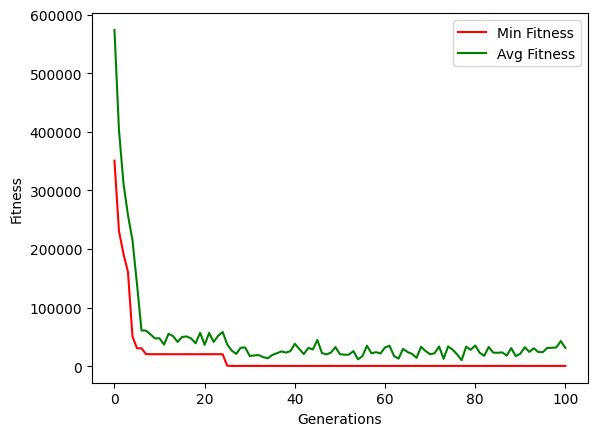

Schedule for each intake and programme:

Programme: SE
  Intake Jan: NDP, RMCE | RMCP, ST, RM
  Intake Mar: MDA | NLP, SQE, MSDP, DM
  Intake Jun: ST, RMCE | RMCP, NDP
  Intake Aug: BDAT, OOSSE, SESE, MSDP
  Intake Oct: MDA | NLP, RMCE | RMCP, RM

Programme: DSBA
  Intake Jan: AML, RMCE | RMCP, TSF | DL
  Intake Mar: ABAV, MDA | NLP, SEM | DPM, DM
  Intake Jun: RMCE | RMCP, BIS, DAP
  Intake Aug: BSSMMA | CIS, SEM | DPM, TSF | DL, BDAT
  Intake Oct: RMCE | RMCP, DAP, AML, MDA | NLP

Violations Summary:
Consecutive module intake violations: 0
RMCE module intake violations: 0
Concurrent module violations: 0
SE student constraint violations: 4

Violations by Student:
Student ABC0109: 1 violations
Student ABC0201: 2 violations
Student ABC0503: 1 violations

SE Student Suggestions:
ABC0013: ['-', '-', '-', '-', '-']
ABC0074: ['RMCE | RMCP', 'MSDP', 'ST', 'OOSSE', 'RM']
ABC0099: ['-', '-', '-', '-', '-']
ABC0106: ['-', '-', '-', '-', '-']
ABC0109: ['RMCE | RMCP', '-', '-', 'OOSSE', 'RM']
ABC

In [ ]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

class Schedule:
    def __init__(self, hardConstraintPenalty):
        self.hardConstraintPenalty = hardConstraintPenalty
        self.intakes = ['Jan', 'Mar', 'Jun', 'Aug', 'Oct']
        self.programme = ['SE', 'DSBA']
        self.modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'IA', 'NDP', 'RMCE | RMCP', 'BDAT', 'DM', 'MDA | NLP', 
                       'BIS', 'AML', 'MMDA', 'DAP', 'ABAV', 'BSSMMA | CIS', 'TSF | DL', 'SEM | DPM', 'ORO | BIA']
        self.slot_intake = 4
        
        # Load both SE and DSBA student data
        self.SE_students_data = self.load_SE_student_data()
        self.DSBA_students_data = self.load_DSBA_student_data()
        
        # Process both SE and DSBA student data
        self.SE_incomplete_modules, self.SE_completed_modules = self.process_SE_student_data()
        self.DSBA_incomplete_modules, self.DSBA_completed_modules = self.process_DSBA_student_data()
                  
    def __len__(self):
        return len(self.intakes) * self.slot_intake * len(self.programme)
    
    def getIntakeSchedule(self, schedule):
        programme_schedule = {programme: {intake: [] for intake in self.intakes} for programme in self.programme}
        index = 0

        for programme in self.programme:
            for intake in self.intakes:
                for _ in range(self.slot_intake):
                    if index < len(schedule):
                        module = self.modules[schedule[index]]
                        programme_schedule[programme][intake].append(module)
                        index += 1
        return programme_schedule
    
    def load_SE_student_data(self):
        SE_students_data = pd.read_excel("data_v1.xlsx")
        SE_students_data = SE_students_data[SE_students_data['COURSE_DESCRIPTION'] != 'MSc in Data Science and Business Analytics']
        SE_students_data = SE_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Managing Software Development Projects': 'MSDP',
            'Reliability Management': 'RM',
            'Object-Oriented Software Systems Engineering': 'OOSSE',
            'Object Oriented Software Systems Engineering': 'OOSSE',
            'Software Engineering Support Environments': 'SESE',
            'Software Quality Engineering': 'SQE',
            'Security Technologies': 'ST',
            'Research Methodology in Computing and Engineering': 'RMCE | RMCP',
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Internet Applications': 'IA',
            'Natural Language Processing': 'MDA | NLP',
            'Network Design and Performance': 'NDP'
        }

        SE_students_data['MODULE_NAME'] = SE_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'RMCE | RMCP', 'BDAT', 'DM', 'IA', 'MDA | NLP', 'NDP']
        SE_students_data = SE_students_data[SE_students_data['MODULE_NAME'].isin(valid_modules)]

        # Handle duplicates
        duplicated_modules = SE_students_data[SE_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)

        SE_students_data = pd.concat([SE_students_data.drop(index=duplicated_modules.index), filtered_students])
        SE_students_data.reset_index(drop=True, inplace=True)
                
        return SE_students_data
    
    def process_SE_student_data(self):
        SE_each_student_info = self.SE_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()
        
        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in SE_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)
        
        # Handle elective modules
        elective = ["BDAT", "DM", "IA", "MDA | NLP", "NDP"]
        for student_id, completed_modules_info in completed_modules.items():
            completed_elective = set(completed_modules_info) & set(elective)

            if len(completed_elective) >= 3:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)
        
        return incomplete_modules, completed_modules
    
    def calculate_SE_student_violations(self, programme_schedule):
        total_violations = 0
        se_schedule = programme_schedule['SE']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.SE_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False  # Track if RMCE | RMCP has been assigned
            violations = 0
            
            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(se_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 1
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 1)
            # Or if RMCE | RMCP is already completed, reduce violations by 1
            elif (student_id in self.SE_completed_modules and 
                'RMCE | RMCP' in self.SE_completed_modules[student_id]):
                violations = max(0, violations - 1)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations

    def load_DSBA_student_data(self):
        DSBA_students_data = pd.read_excel("data_v1.xlsx")
        DSBA_students_data = DSBA_students_data[DSBA_students_data['COURSE_DESCRIPTION'] != 'MSc in Software Engineering']
        DSBA_students_data = DSBA_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Business Intelligence Systems': 'BIS',
            'Applied Machine Learning': 'AML',
            'Applied Machine Learning ': 'AML',
            'Research Methods for Capstone Project': 'RMCP',
            'Research Methodology for Capstone Project': 'RMCP',
            'Research Methodology in Computing and Engineering': 'RMCP',
            'Research Methodology': 'RMCP',
            'Research Methods for Capstone Project': 'RMCP',
            'Multivariate Methods for Data Analysis': 'MMDA',
            'Data Analytical Programming': 'DAP',
            'Advanced Business Analytics and Visualization': 'ABAV',
            'Advanced Business Analytics and Visualisation': 'ABAV',
            'Behavioural Science, Social Media and Marketing Analytics': 'BSSMMA',
            'Behavioural Science,Social Media and Marketing Analytics': 'BSSMMA',
            'Cloud Infrastructure and Services': 'CIS',
            'Time Series Analysis and Forecasting': 'TSF',
            'Time Series Analysis and Forecasting ': 'TSF',
            'Deep Learning': 'DL',
            'Multilevel Data Analysis': 'MDA',
            'Natural Language Processing': 'NLP',
            'Strategies in Emerging Markets': 'SEM',
            'Data Protection and Management': 'DPM',
            'Operational Research and Optimisation': 'ORO',
            'Operational Research Optimisation': 'ORO',
            'Building IoT Applications': 'BIA'
        }

        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['BDAT', 'DM', 'BIS', 'AML', 'RMCP', 'MMDA', 'DAP', 'ABAV', 'BSSMMA', 'CIS',
                        'TSF', 'DL', 'MDA', 'NLP', 'SEM', 'DPM', 'ORO', 'BIA']
        DSBA_students_data = DSBA_students_data[DSBA_students_data['MODULE_NAME'].isin(valid_modules)]
        
        duplicated_modules = DSBA_students_data[DSBA_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]

        # Handle duplicates
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)
        DSBA_students_data = pd.concat([DSBA_students_data.drop(index=duplicated_modules.index), filtered_students])

        # Handle DSBA special cases
        DSBA_students_data = self.handle_DSBA_special_cases(DSBA_students_data)

        # Final module name changes
        final_module_changes = {
            'RMCP': 'RMCE | RMCP',
            'NLP': 'MDA | NLP',
            'MDA': 'MDA | NLP',
            'BSSMMA': 'BSSMMA | CIS',
            'CIS': 'BSSMMA | CIS',
            'TSF': 'TSF | DL',
            'DL': 'TSF | DL',
            'SEM': 'SEM | DPM',
            'DPM': 'SEM | DPM',
            'ORO': 'ORO | BIA',
            'BIA': 'ORO | BIA'
        }
        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(final_module_changes)
        
        return DSBA_students_data

    def handle_DSBA_special_cases(self, df):
        # Function to check if student has specific modules
        def has_modules(group, module_set):
            return module_set.issubset(group['MODULE_NAME'].unique())

        # Handle BSSMMA, TSF, CIS case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "CIS"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'CIS')
        df = df[~rows_to_drop]
        
        # Handle BSSMMA, TSF, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'DL')
        df = df[~rows_to_drop]

        # Handle TSF, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"TSF", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'TSF')
        df = df[~rows_to_drop]

        # Handle BSSMMA, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'BSSMMA')
        df = df[~rows_to_drop]

        # Filter out non BI pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"NLP", "DPM", "BIA"})] 
            if {"BSSMMA", "TSF"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )
        
        # Filter out non DE pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"MDA", "SEM", "ORO"})] 
            if {"CIS", "DL"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )

        return df

    def process_DSBA_student_data(self):
        DSBA_each_student_info = self.DSBA_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()

        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in DSBA_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)

        # Handle electives
        elective = ["MDA | NLP", "SEM | DPM", "ORO | BIA"]
        for student_id in completed_modules:
            completed_elective = set(completed_modules[student_id]) & set(elective)
            if len(completed_elective) >= 1:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)

        return incomplete_modules, completed_modules

    def calculate_DSBA_student_violations(self, programme_schedule):
        total_violations = 0
        dsba_schedule = programme_schedule['DSBA']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.DSBA_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False
            violations = 0

            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(dsba_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                    
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 2
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 2)
            # Or if RMCE | RMCP is already completed, reduce violations by 2
            elif (student_id in self.DSBA_completed_modules and 
                'RMCE | RMCP' in self.DSBA_completed_modules[student_id]):
                violations = max(0, violations - 2)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations
    
    def getCost(self, schedule):
        if not self.isValidProgrammeRanges(schedule):
            return float('inf')
            
        module_dict = self.getIntakeSchedule(schedule)
        consecutivemoduleintake = self.countConsecutivemoduleintake(module_dict)
        rmce_violations = self.rmceintake(module_dict)
        concurrent_violations = self.concurrentModuleViolations(module_dict)
        se_student_violations, _, _ = self.calculate_SE_student_violations(module_dict)
        dsba_student_violations, _, _ = self.calculate_DSBA_student_violations(module_dict)
        
        hardContstraintViolations = (
            consecutivemoduleintake*1000 +
            rmce_violations*10000 +
            concurrent_violations*1000 +
            se_student_violations +
            dsba_student_violations)
        
        return self.hardConstraintPenalty * hardContstraintViolations

    def isValidProgrammeRanges(self, schedule):
        slots_per_programme = len(self.intakes) * self.slot_intake
        
        se_modules = schedule[:slots_per_programme]
        if not all(0 <= module <= 11 for module in se_modules):
            return False
            
        dsba_modules = schedule[slots_per_programme:]
        if not all(8 <= module <= 20 for module in dsba_modules):
            return False
            
        return True  
    
    def countConsecutivemoduleintake(self, programme_schedule):
        violations = 0
        for programme, intakes in programme_schedule.items():
            intakes_list = list(intakes.values())
            for i in range(len(intakes_list) - 1):
                intake_1 = intakes_list[i]
                intake_2 = intakes_list[i + 1]

                for module in intake_1:
                    if module in intake_2:
                        violations += 1
        return violations

    def rmceintake(self, programme_schedule):
        violations = 0
        required_intakes = ['Jan', 'Jun', 'Oct']

        for programme, intakes in programme_schedule.items():
            for intake in required_intakes:
                if intake in intakes:
                    if 'RMCE | RMCP' not in intakes[intake]:
                        violations += 1
        return violations
    
    def concurrentModuleViolations(self, programme_schedule):
        violations = 0
        matching_dict_SE = {}
        matching_dict_DSBA = {}
        concurrent_modules = ['BDAT', 'DM', 'MDA | NLP']
        
        # Check SE programme
        for intake, se_modules in programme_schedule['SE'].items():
            matching_modules = [module for module in concurrent_modules if module in se_modules]
            if matching_modules:
                matching_dict_SE[intake] = matching_modules
                  
        # Check DSBA programme
        for intake, dsba_modules in programme_schedule['DSBA'].items():
            matching_modules = [module for module in concurrent_modules if module in dsba_modules]
            if matching_modules:
                matching_dict_DSBA[intake] = matching_modules
            
        intakes = set(matching_dict_SE.keys()).union(matching_dict_DSBA.keys())
        
        # Compare for each intake
        for intake in intakes:
            if intake in matching_dict_SE and intake in matching_dict_DSBA:
                if matching_dict_DSBA[intake] != matching_dict_SE[intake]:
                    violations += 1
                elif matching_dict_SE[intake] != matching_dict_DSBA[intake]:
                    violations +=1
            else:
                violations +=1
                        
        return violations

    def removeDuplicatedModules(self, programme_schedule):
        for programme, intakes in programme_schedule.items():
            for intake, modules in intakes.items():
                seen_modules = set()
                unique_modules = []
                for module in modules:
                    if module not in seen_modules:
                        unique_modules.append(module)
                        seen_modules.add(module)
                intakes[intake] = unique_modules 
        return programme_schedule
    
    def print_schedule(self, schedule):
        programme_schedule = self.getIntakeSchedule(schedule)
        
        # Remove duplicates before printing
        programme_schedule = self.removeDuplicatedModules(programme_schedule)

        print("Schedule for each intake and programme:")
        for programme, intakes in programme_schedule.items():
            print(f"\nProgramme: {programme}")
            for intake, modules in intakes.items():
                print(f"  Intake {intake}: {', '.join(modules) if modules else 'No modules assigned'}")

        se_violations, se_suggestions, se_student_violations = self.calculate_SE_student_violations(programme_schedule)
        dsba_violations, dsba_suggestions, dsba_student_violations = self.calculate_DSBA_student_violations(programme_schedule)
        
        print("\nViolations Summary:")
        print(f"Consecutive module intake violations: {self.countConsecutivemoduleintake(programme_schedule)}")
        print(f"RMCE module intake violations: {self.rmceintake(programme_schedule)}")
        print(f"Concurrent module violations: {self.concurrentModuleViolations(programme_schedule)}")
        print(f"SE student constraint violations: {se_violations}")
        print("\nViolations by Student:")
        for student_id, violations in se_student_violations.items():
            if violations > 0:
                print(f"Student {student_id}: {violations} violations")
        print("\nSE Student Suggestions:")
        for student_id, modules in se_suggestions.items():
            print(f"{student_id}: {modules}") 
        
        print(f"DSBA student constraint violations: {dsba_violations}")
        print("\nViolations by Student:")
        for student_id, violations in dsba_student_violations.items():
            if violations > 0:
                print(f"Student {student_id}: {violations} violations")
        print("\nDSBA Student Suggestions:")
        for student_id, modules in dsba_suggestions.items():
            print(f"{student_id}: {modules}")

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

def init_individual():
    slots_per_programme = len(schedule.intakes) * schedule.slot_intake
    se_modules = [random.randint(0, 11) for _ in range(slots_per_programme)]
    dsba_modules = [random.randint(8, 20) for _ in range(slots_per_programme)]
    return creator.individual(se_modules + dsba_modules)

def constrained_mutate(individual, indpb):
    slots_per_programme = len(schedule.intakes) * schedule.slot_intake
    for i in range(len(individual)):
        if random.random() < indpb:
            if i < slots_per_programme:
                individual[i] = random.randint(0, 11)
            else:
                individual[i] = random.randint(8, 20)
    return individual,

# Setup and run GA
schedule = Schedule(hardConstraintPenalty=10)
pop_size = 100
generations = 100
prob_cx = 0.8
prob_mut = 0.2
random.seed(42)

toolbox = base.Toolbox()
creator.create('fitnessMin', base.Fitness, weights=(-1.0,))
creator.create('individual', list, fitness=creator.fitnessMin)
toolbox.register('individual', init_individual)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('evaluate', lambda x: (schedule.getCost(x),))
toolbox.register('select', tools.selTournament, tournsize=40)
toolbox.register('mate', tools.cxUniform, indpb=0.2)
toolbox.register('mutate', constrained_mutate, indpb=0.2)

pop = toolbox.population(n=pop_size)
stats = tools.Statistics(lambda x: x.fitness.values)
stats.register('min', np.min)
stats.register('avg', np.mean)

hof = tools.HallOfFame(10)

final_pop, logbook = eaSimpleWithElitism(
    pop,
    toolbox,
    prob_cx,
    prob_mut,
    generations,
    stats,
    hof,
    True
)

plt.plot(logbook.select('min'), color='red', label='Min Fitness')
plt.plot(logbook.select('avg'), color='green', label='Avg Fitness')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.legend()
plt.show()

schedule.print_schedule(hof[0])
print("Best Chromosome:", hof[0])
print("Chromosome Length:", len(hof[0]))

GA Grid Serach Hyperparamter Tuning, 827m 38.2s

Testing parameters: {'pop_size': 50, 'generations': 50, 'prob_cx': 0.7, 'prob_mut': 0.1, 'tournament_size': 20, 'cx_indpb': 0.1, 'mut_indpb': 0.1}
Testing parameters: {'pop_size': 50, 'generations': 50, 'prob_cx': 0.7, 'prob_mut': 0.1, 'tournament_size': 20, 'cx_indpb': 0.1, 'mut_indpb': 0.15}
Testing parameters: {'pop_size': 50, 'generations': 50, 'prob_cx': 0.7, 'prob_mut': 0.1, 'tournament_size': 20, 'cx_indpb': 0.1, 'mut_indpb': 0.2}
Testing parameters: {'pop_size': 50, 'generations': 50, 'prob_cx': 0.7, 'prob_mut': 0.1, 'tournament_size': 20, 'cx_indpb': 0.15, 'mut_indpb': 0.1}
Testing parameters: {'pop_size': 50, 'generations': 50, 'prob_cx': 0.7, 'prob_mut': 0.1, 'tournament_size': 20, 'cx_indpb': 0.15, 'mut_indpb': 0.15}
Testing parameters: {'pop_size': 50, 'generations': 50, 'prob_cx': 0.7, 'prob_mut': 0.1, 'tournament_size': 20, 'cx_indpb': 0.15, 'mut_indpb': 0.2}
Testing parameters: {'pop_size': 50, 'generations': 50, 'prob_cx': 0.7, 'prob_mut': 0.1, 'tournament_size': 20, '

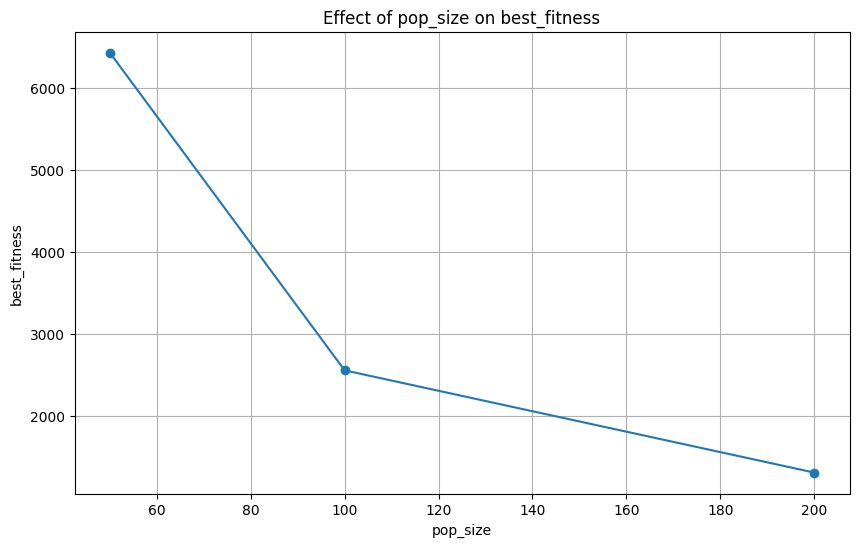

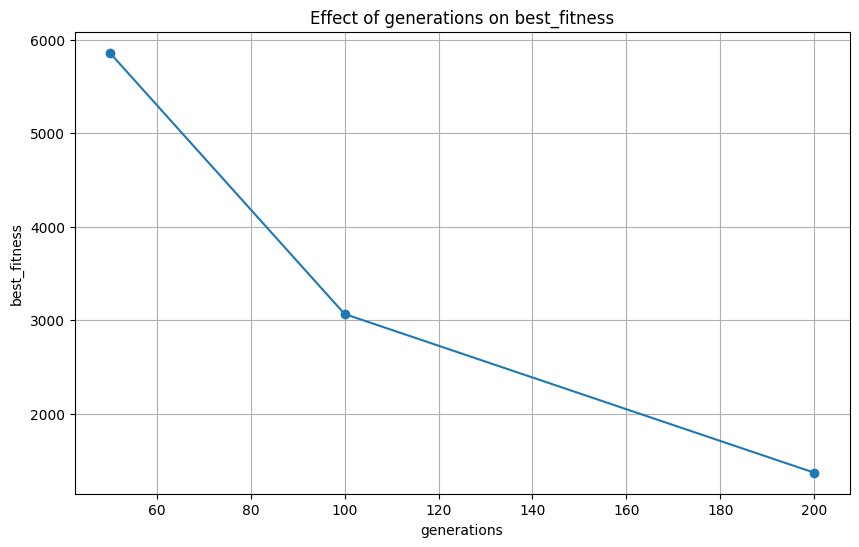

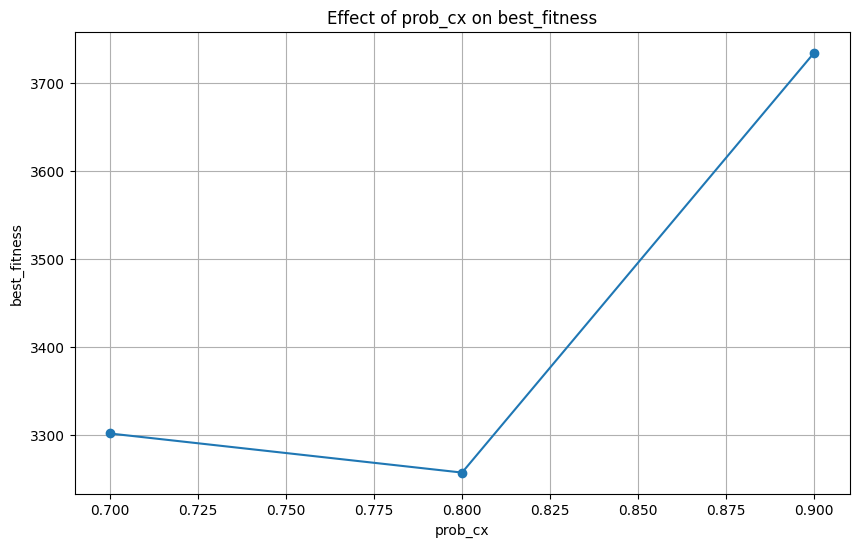

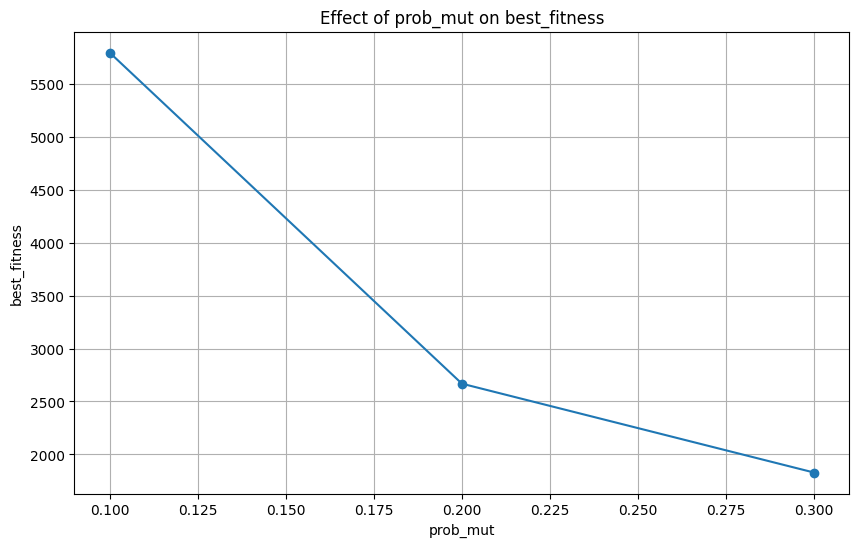

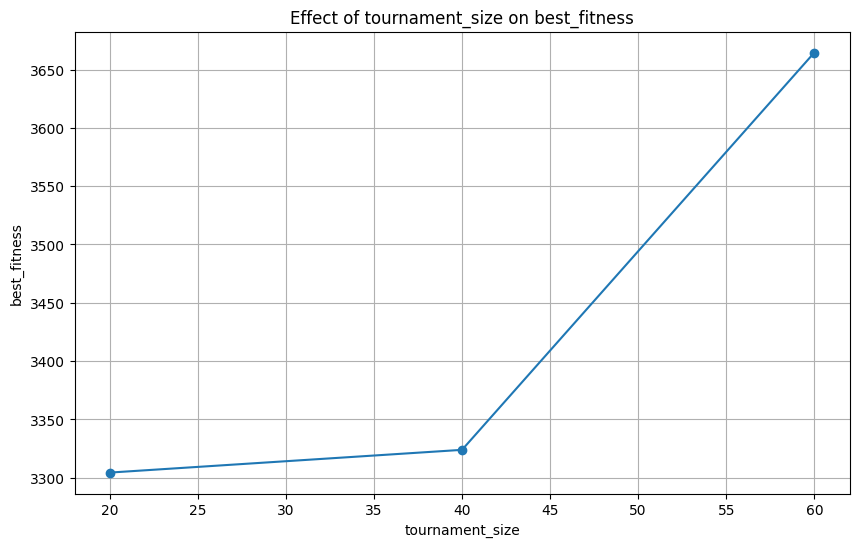

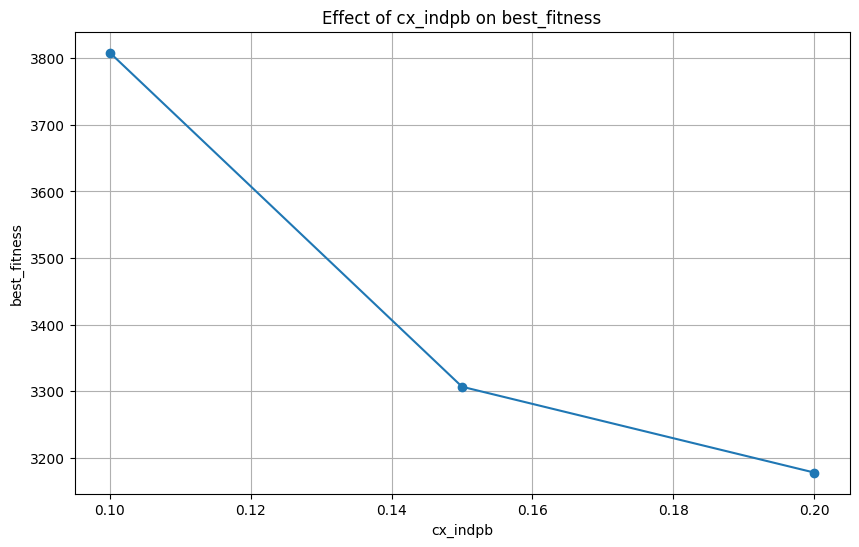

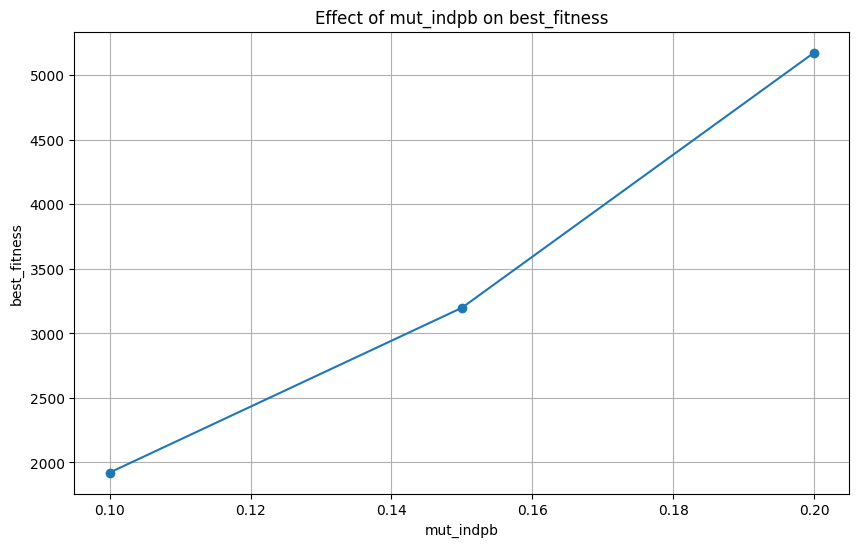

In [6]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import itertools
import time

class Schedule:
    def __init__(self, hardConstraintPenalty):
        self.hardConstraintPenalty = hardConstraintPenalty
        self.intakes = ['Jan', 'Mar', 'Jun', 'Aug', 'Oct']
        self.programme = ['SE', 'DSBA']
        self.modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'IA', 'NDP', 'RMCE | RMCP', 'BDAT', 'DM', 'MDA | NLP', 
                       'BIS', 'AML', 'MMDA', 'DAP', 'ABAV', 'BSSMMA | CIS', 'TSF | DL', 'SEM | DPM', 'ORO | BIA']
        self.slot_intake = 4
        
        # Load both SE and DSBA student data
        self.SE_students_data = self.load_SE_student_data()
        self.DSBA_students_data = self.load_DSBA_student_data()
        
        # Process both SE and DSBA student data
        self.SE_incomplete_modules, self.SE_completed_modules = self.process_SE_student_data()
        self.DSBA_incomplete_modules, self.DSBA_completed_modules = self.process_DSBA_student_data()
                  
    def __len__(self):
        return len(self.intakes) * self.slot_intake * len(self.programme)
    
    def getIntakeSchedule(self, schedule):
        programme_schedule = {programme: {intake: [] for intake in self.intakes} for programme in self.programme}
        index = 0

        for programme in self.programme:
            for intake in self.intakes:
                for _ in range(self.slot_intake):
                    if index < len(schedule):
                        module = self.modules[schedule[index]]
                        programme_schedule[programme][intake].append(module)
                        index += 1
        return programme_schedule
    
    def load_SE_student_data(self):
        SE_students_data = pd.read_excel("data_v1.xlsx")
        SE_students_data = SE_students_data[SE_students_data['COURSE_DESCRIPTION'] != 'MSc in Data Science and Business Analytics']
        SE_students_data = SE_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Managing Software Development Projects': 'MSDP',
            'Reliability Management': 'RM',
            'Object-Oriented Software Systems Engineering': 'OOSSE',
            'Object Oriented Software Systems Engineering': 'OOSSE',
            'Software Engineering Support Environments': 'SESE',
            'Software Quality Engineering': 'SQE',
            'Security Technologies': 'ST',
            'Research Methodology in Computing and Engineering': 'RMCE | RMCP',
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Internet Applications': 'IA',
            'Natural Language Processing': 'MDA | NLP',
            'Network Design and Performance': 'NDP'
        }

        SE_students_data['MODULE_NAME'] = SE_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'RMCE | RMCP', 'BDAT', 'DM', 'IA', 'MDA | NLP', 'NDP']
        SE_students_data = SE_students_data[SE_students_data['MODULE_NAME'].isin(valid_modules)]

        # Handle duplicates
        duplicated_modules = SE_students_data[SE_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)

        SE_students_data = pd.concat([SE_students_data.drop(index=duplicated_modules.index), filtered_students])
        SE_students_data.reset_index(drop=True, inplace=True)
                
        return SE_students_data
    
    def process_SE_student_data(self):
        SE_each_student_info = self.SE_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()
        
        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in SE_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)
        
        # Handle elective modules
        elective = ["BDAT", "DM", "IA", "MDA | NLP", "NDP"]
        for student_id, completed_modules_info in completed_modules.items():
            completed_elective = set(completed_modules_info) & set(elective)

            if len(completed_elective) >= 3:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)
        
        return incomplete_modules, completed_modules
    
    def calculate_SE_student_violations(self, programme_schedule):
        total_violations = 0
        se_schedule = programme_schedule['SE']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.SE_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False  # Track if RMCE | RMCP has been assigned
            violations = 0
            
            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(se_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 1
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 1)
            # Or if RMCE | RMCP is already completed, reduce violations by 1
            elif (student_id in self.SE_completed_modules and 
                'RMCE | RMCP' in self.SE_completed_modules[student_id]):
                violations = max(0, violations - 1)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations

    def load_DSBA_student_data(self):
        DSBA_students_data = pd.read_excel("data_v1.xlsx")
        DSBA_students_data = DSBA_students_data[DSBA_students_data['COURSE_DESCRIPTION'] != 'MSc in Software Engineering']
        DSBA_students_data = DSBA_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Business Intelligence Systems': 'BIS',
            'Applied Machine Learning': 'AML',
            'Applied Machine Learning ': 'AML',
            'Research Methods for Capstone Project': 'RMCP',
            'Research Methodology for Capstone Project': 'RMCP',
            'Research Methodology in Computing and Engineering': 'RMCP',
            'Research Methodology': 'RMCP',
            'Research Methods for Capstone Project': 'RMCP',
            'Multivariate Methods for Data Analysis': 'MMDA',
            'Data Analytical Programming': 'DAP',
            'Advanced Business Analytics and Visualization': 'ABAV',
            'Advanced Business Analytics and Visualisation': 'ABAV',
            'Behavioural Science, Social Media and Marketing Analytics': 'BSSMMA',
            'Behavioural Science,Social Media and Marketing Analytics': 'BSSMMA',
            'Cloud Infrastructure and Services': 'CIS',
            'Time Series Analysis and Forecasting': 'TSF',
            'Time Series Analysis and Forecasting ': 'TSF',
            'Deep Learning': 'DL',
            'Multilevel Data Analysis': 'MDA',
            'Natural Language Processing': 'NLP',
            'Strategies in Emerging Markets': 'SEM',
            'Data Protection and Management': 'DPM',
            'Operational Research and Optimisation': 'ORO',
            'Operational Research Optimisation': 'ORO',
            'Building IoT Applications': 'BIA'
        }

        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['BDAT', 'DM', 'BIS', 'AML', 'RMCP', 'MMDA', 'DAP', 'ABAV', 'BSSMMA', 'CIS',
                        'TSF', 'DL', 'MDA', 'NLP', 'SEM', 'DPM', 'ORO', 'BIA']
        DSBA_students_data = DSBA_students_data[DSBA_students_data['MODULE_NAME'].isin(valid_modules)]
        
        duplicated_modules = DSBA_students_data[DSBA_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]

        # handle duplicates
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)
        DSBA_students_data = pd.concat([DSBA_students_data.drop(index=duplicated_modules.index), filtered_students])

        # Handle DSBA special cases
        DSBA_students_data = self.handle_DSBA_special_cases(DSBA_students_data)

        # Final module name changes
        final_module_changes = {
            'RMCP': 'RMCE | RMCP',
            'NLP': 'MDA | NLP',
            'MDA': 'MDA | NLP',
            'BSSMMA': 'BSSMMA | CIS',
            'CIS': 'BSSMMA | CIS',
            'TSF': 'TSF | DL',
            'DL': 'TSF | DL',
            'SEM': 'SEM | DPM',
            'DPM': 'SEM | DPM',
            'ORO': 'ORO | BIA',
            'BIA': 'ORO | BIA'
        }
        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(final_module_changes)
        
        return DSBA_students_data

    def handle_DSBA_special_cases(self, df):
        # Function to check if student has specific modules
        def has_modules(group, module_set):
            return module_set.issubset(group['MODULE_NAME'].unique())

        # Handle BSSMMA, TSF, CIS case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "CIS"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'CIS')
        df = df[~rows_to_drop]
        
        # Handle BSSMMA, TSF, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'DL')
        df = df[~rows_to_drop]

        # Handle TSF, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"TSF", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'TSF')
        df = df[~rows_to_drop]

        # Handle BSSMMA, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'BSSMMA')
        df = df[~rows_to_drop]

        ## Filter out non BI pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"NLP", "DPM", "BIA"})] 
            if {"BSSMMA", "TSF"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )
        
        # Filter out non DE pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"MDA", "SEM", "ORO"})] 
            if {"CIS", "DL"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )

        return df

    def process_DSBA_student_data(self):
        DSBA_each_student_info = self.DSBA_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()

        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in DSBA_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)

        # Handle electives
        elective = ["MDA | NLP", "SEM | DPM", "ORO | BIA"]
        for student_id in completed_modules:
            completed_elective = set(completed_modules[student_id]) & set(elective)
            if len(completed_elective) >= 1:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)

        return incomplete_modules, completed_modules

    def calculate_DSBA_student_violations(self, programme_schedule):
        total_violations = 0
        dsba_schedule = programme_schedule['DSBA']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.DSBA_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False
            violations = 0

            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(dsba_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                    
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 2
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 2)
            # Or if RMCE | RMCP is already completed, reduce violations by 2
            elif (student_id in self.DSBA_completed_modules and 
                'RMCE | RMCP' in self.DSBA_completed_modules[student_id]):
                violations = max(0, violations - 2)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations
    
    def getCost(self, schedule):
        if not self.isValidProgrammeRanges(schedule):
            return float('inf')
            
        module_dict = self.getIntakeSchedule(schedule)
        consecutivemoduleintake = self.countConsecutivemoduleintake(module_dict)
        rmce_violations = self.rmceintake(module_dict)
        concurrent_violations = self.concurrentModuleViolations(module_dict)
        se_student_violations, _, _ = self.calculate_SE_student_violations(module_dict)
        dsba_student_violations, _, _ = self.calculate_DSBA_student_violations(module_dict)
        
        hardContstraintViolations = (
            consecutivemoduleintake*1000 +
            rmce_violations*10000 +
            concurrent_violations*1000 +
            se_student_violations +
            dsba_student_violations)
        
        return self.hardConstraintPenalty * hardContstraintViolations

    def isValidProgrammeRanges(self, schedule):
        slots_per_programme = len(self.intakes) * self.slot_intake
        
        se_modules = schedule[:slots_per_programme]
        if not all(0 <= module <= 11 for module in se_modules):
            return False
            
        dsba_modules = schedule[slots_per_programme:]
        if not all(8 <= module <= 20 for module in dsba_modules):
            return False
            
        return True  
    
    def countConsecutivemoduleintake(self, programme_schedule):
        violations = 0
        for programme, intakes in programme_schedule.items():
            intakes_list = list(intakes.values())
            for i in range(len(intakes_list) - 1):
                intake_1 = intakes_list[i]
                intake_2 = intakes_list[i + 1]

                for module in intake_1:
                    if module in intake_2:
                        violations += 1
        return violations

    def rmceintake(self, programme_schedule):
        violations = 0
        required_intakes = ['Jan', 'Jun', 'Oct']

        for programme, intakes in programme_schedule.items():
            for intake in required_intakes:
                if intake in intakes:
                    if 'RMCE | RMCP' not in intakes[intake]:
                        violations += 1
        return violations
    
    def concurrentModuleViolations(self, programme_schedule):
        violations = 0
        matching_dict_SE = {}
        matching_dict_DSBA = {}
        concurrent_modules = ['BDAT', 'DM', 'MDA | NLP']
        
        # Check SE programme
        for intake, se_modules in programme_schedule['SE'].items():
            matching_modules = [module for module in concurrent_modules if module in se_modules]
            if matching_modules:
                matching_dict_SE[intake] = matching_modules
                  
        # Check DSBA programme
        for intake, dsba_modules in programme_schedule['DSBA'].items():
            matching_modules = [module for module in concurrent_modules if module in dsba_modules]
            if matching_modules:
                matching_dict_DSBA[intake] = matching_modules
            
        intakes = set(matching_dict_SE.keys()).union(matching_dict_DSBA.keys())
        
        # Compare for each intake
        for intake in intakes:
            if intake in matching_dict_SE and intake in matching_dict_DSBA:
                if matching_dict_DSBA[intake] != matching_dict_SE[intake]:
                    violations += 1
                elif matching_dict_SE[intake] != matching_dict_DSBA[intake]:
                    violations +=1
            else:
                violations +=1
                        
        return violations

    def removeDuplicatedModules(self, programme_schedule):
        for programme, intakes in programme_schedule.items():
            for intake, modules in intakes.items():
                seen_modules = set()
                unique_modules = []
                for module in modules:
                    if module not in seen_modules:
                        unique_modules.append(module)
                        seen_modules.add(module)
                intakes[intake] = unique_modules
        return programme_schedule
    
    def print_schedule(self, schedule):
        programme_schedule = self.getIntakeSchedule(schedule)
        
        # Remove duplicates before printing
        programme_schedule = self.removeDuplicatedModules(programme_schedule)

        print("Schedule for each intake and programme:")
        for programme, intakes in programme_schedule.items():
            print(f"\nProgramme: {programme}")
            for intake, modules in intakes.items():
                print(f"  Intake {intake}: {', '.join(modules) if modules else 'No modules assigned'}")

        se_violations, se_suggestions, se_student_violations = self.calculate_SE_student_violations(programme_schedule)
        dsba_violations, dsba_suggestions, dsba_student_violations = self.calculate_DSBA_student_violations(programme_schedule)
        
        print("\nViolations Summary:")
        print(f"Consecutive module intake violations: {self.countConsecutivemoduleintake(programme_schedule)}")
        print(f"RMCE module intake violations: {self.rmceintake(programme_schedule)}")
        print(f"Concurrent module violations: {self.concurrentModuleViolations(programme_schedule)}")
        print(f"SE student constraint violations: {se_violations}")
        print("\nViolations by Student:")
        for student_id, violations in se_student_violations.items():
            if violations > 0:
                print(f"Student {student_id}: {violations} violations")
        print("\nSE Student Suggestions:")
        for student_id, modules in se_suggestions.items():
            print(f"{student_id}: {modules}") 
        
        print(f"DSBA student constraint violations: {dsba_violations}")
        print("\nViolations by Student:")
        for student_id, violations in dsba_student_violations.items():
            if violations > 0:
                print(f"Student {student_id}: {violations} violations")
        print("\nDSBA Student Suggestions:")
        for student_id, modules in dsba_suggestions.items():
            print(f"{student_id}: {modules}")

def init_individual():
    slots_per_programme = len(schedule.intakes) * schedule.slot_intake
    se_modules = [random.randint(0, 11) for _ in range(slots_per_programme)]
    dsba_modules = [random.randint(8, 20) for _ in range(slots_per_programme)]
    return creator.individual(se_modules + dsba_modules)

def constrained_mutate(individual, indpb):
    slots_per_programme = len(schedule.intakes) * schedule.slot_intake
    for i in range(len(individual)):
        if random.random() < indpb:
            if i < slots_per_programme:
                individual[i] = random.randint(0, 11)
            else:
                individual[i] = random.randint(8, 20)
    return individual,

def run_ga_with_params(schedule, pop_size, generations, prob_cx, prob_mut, tournament_size, cx_indpb, mut_indpb, seed=42):
    """
    Run genetic algorithm with specified parameters and return best fitness
    """
    random.seed(seed)
    
    # Reset DEAP creators to avoid naming conflicts
    if 'fitnessMin' in creator.__dict__:
        del creator.fitnessMin
    if 'individual' in creator.__dict__:
        del creator.individual
        
    # GA
    toolbox = base.Toolbox()
    creator.create('fitnessMin', base.Fitness, weights=(-1.0,))
    creator.create('individual', list, fitness=creator.fitnessMin)
    toolbox.register('individual', init_individual)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)
    toolbox.register('evaluate', lambda x: (schedule.getCost(x),))
    toolbox.register('select', tools.selTournament, tournsize=tournament_size)
    toolbox.register('mate', tools.cxUniform, indpb=cx_indpb)
    toolbox.register('mutate', constrained_mutate, indpb=mut_indpb)

    # Run GA
    start_time = time.time()
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(10)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('min', np.min)
    stats.register('avg', np.mean)
    
    final_pop, logbook = algorithms.eaSimple(
        pop,
        toolbox,
        prob_cx,
        prob_mut,
        generations,
        stats=stats,
        halloffame=hof,
        verbose=False
    )
    
    runtime = time.time() - start_time
    
    return {
        'best_fitness': hof[0].fitness.values[0],
        'avg_fitness': np.mean([ind.fitness.values[0] for ind in final_pop]),
        'runtime': runtime,
    }

def grid_search():
    param_grid = {
        'pop_size': [50, 100, 200],
        'generations': [50, 100, 200],
        'prob_cx': [0.7, 0.8, 0.9],
        'prob_mut': [0.1, 0.2, 0.3],
        'tournament_size': [20, 40, 60],
        'cx_indpb': [0.1, 0.15, 0.2],
        'mut_indpb': [0.1, 0.15, 0.2]
    }
    
    param_combinations = [dict(zip(param_grid.keys(), v)) 
                        for v in itertools.product(*param_grid.values())]
    
    schedule = Schedule(hardConstraintPenalty=10)
    
    results = []
    
    for params in param_combinations:
        print(f"Testing parameters: {params}")
        
        # Run multiple trials for statistical significance
        n_trials = 3
        trial_results = []
        
        for trial in range(n_trials):
            result = run_ga_with_params(
                schedule,
                params['pop_size'],
                params['generations'],
                params['prob_cx'],
                params['prob_mut'],
                params['tournament_size'],
                params['cx_indpb'],
                params['mut_indpb'],
                seed=42+trial
            )
            trial_results.append(result)
        
        # Average results across trials
        avg_result = {
            'pop_size': params['pop_size'],
            'generations': params['generations'],
            'prob_cx': params['prob_cx'],
            'prob_mut': params['prob_mut'],
            'tournament_size': params['tournament_size'],
            'cx_indpb': params['cx_indpb'],
            'mut_indpb': params['mut_indpb'],
            'best_fitness': np.mean([r['best_fitness'] for r in trial_results]),
            'avg_fitness': np.mean([r['avg_fitness'] for r in trial_results]),
            'runtime': np.mean([r['runtime'] for r in trial_results]),
        }
        
        results.append(avg_result)
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    results_df['score'] = results_df['best_fitness'] * 0.8 + \
                         results_df['runtime'].rank(pct=True) * 0.2
    
    results_df = results_df.sort_values('score')
    
    return results_df

results = grid_search()

print("\nTop 3 parameter combinations:")
print(results.head(3))

# Plot parameter importance
import matplotlib.pyplot as plt

def plot_parameter_importance(results_df, parameter, metric='best_fitness'):
    plt.figure(figsize=(10, 6))
    grouped = results_df.groupby(parameter)[metric].mean()
    grouped.plot(marker='o')
    plt.title(f'Effect of {parameter} on {metric}')
    plt.xlabel(parameter)
    plt.ylabel(metric)
    plt.grid(True)
    plt.show()

for param in ['pop_size', 'generations', 'prob_cx', 'prob_mut', 'tournament_size', 'cx_indpb', 'mut_indpb']:
    plot_parameter_importance(results, param)

Optimized GA

gen	nevals	min   	avg   
0  	200   	261450	566748
1  	143   	212110	397385
2  	136   	91300 	267108
3  	146   	91300 	198897
4  	157   	51410 	119199
5  	157   	40450 	95033.1
6  	159   	21390 	60381.6
7  	147   	21300 	47247.9
8  	153   	20490 	35678.4
9  	157   	20490 	38579.6
10 	151   	20290 	32447.5
11 	156   	20290 	30937.8
12 	163   	20270 	34919  
13 	168   	20250 	34632.7
14 	150   	20220 	35691.7
15 	155   	20200 	28066.3
16 	166   	20170 	30842.6
17 	152   	20170 	34973.9
18 	161   	20170 	40457.7
19 	152   	20170 	35691.6
20 	152   	20170 	32516  
21 	154   	20170 	40606.3
22 	144   	20170 	33587.3
23 	153   	20130 	34600.5
24 	161   	20110 	29883.9
25 	154   	20110 	34314.4
26 	156   	20100 	32885.7
27 	155   	20100 	37389.4
28 	153   	20100 	37235.2
29 	150   	20100 	29119.2
30 	157   	20100 	35347.1
31 	160   	20100 	29820.5
32 	154   	20100 	31837.7
33 	140   	20080 	31076.8
34 	148   	20070 	35374.7
35 	144   	20050 	43166.4
36 	164   	10060 	38045.1
37 	153   	10040 	

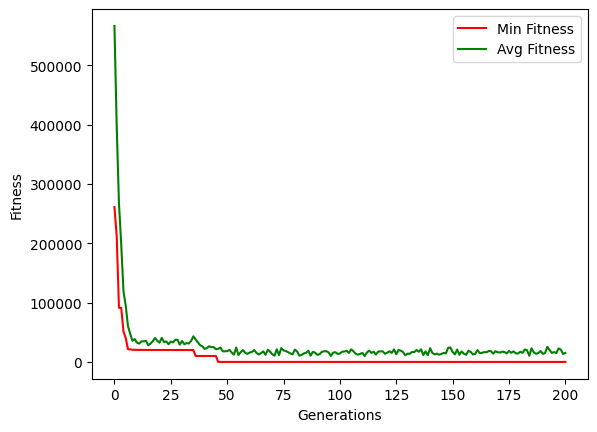

Schedule for each intake and programme:

Programme: SE
  Intake Jan: RM, DM, OOSSE, RMCE | RMCP
  Intake Mar: SQE, MSDP, BDAT
  Intake Jun: RMCE | RMCP, SESE, RM, IA
  Intake Aug: MDA | NLP, DM, OOSSE
  Intake Oct: ST, SQE, RMCE | RMCP

Programme: DSBA
  Intake Jan: BSSMMA | CIS, TSF | DL, RMCE | RMCP, DM
  Intake Mar: BDAT, BIS, DAP, AML
  Intake Jun: ABAV, MMDA, RMCE | RMCP, TSF | DL
  Intake Aug: BIS, DM, BSSMMA | CIS, MDA | NLP
  Intake Oct: ABAV, TSF | DL, DAP, RMCE | RMCP

Violations Summary:
Consecutive module intake violations: 0
RMCE module intake violations: 0
Concurrent module violations: 0
SE student constraint violations: 0

Violations by Student:

SE Student Suggestions:
ABC0013: ['-', '-', '-', '-', '-']
ABC0074: ['RMCE | RMCP', 'MSDP', 'RM', 'OOSSE', 'ST']
ABC0099: ['-', '-', '-', '-', '-']
ABC0106: ['-', '-', '-', '-', '-']
ABC0109: ['RMCE | RMCP', '-', 'RM', 'OOSSE', '-']
ABC0110: ['RM', '-', '-', '-', '-']
ABC0112: ['-', '-', '-', '-', '-']
ABC0122: ['RMCE | RMCP', '

In [ ]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

class Schedule:
    def __init__(self, hardConstraintPenalty):
        self.hardConstraintPenalty = hardConstraintPenalty
        self.intakes = ['Jan', 'Mar', 'Jun', 'Aug', 'Oct']
        self.programme = ['SE', 'DSBA']
        self.modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'IA', 'NDP', 'RMCE | RMCP', 'BDAT', 'DM', 'MDA | NLP', 
                       'BIS', 'AML', 'MMDA', 'DAP', 'ABAV', 'BSSMMA | CIS', 'TSF | DL', 'SEM | DPM', 'ORO | BIA']
        self.slot_intake = 4
        
        # Load both SE and DSBA student data
        self.SE_students_data = self.load_SE_student_data()
        self.DSBA_students_data = self.load_DSBA_student_data()
        
        # Process both SE and DSBA student data
        self.SE_incomplete_modules, self.SE_completed_modules = self.process_SE_student_data()
        self.DSBA_incomplete_modules, self.DSBA_completed_modules = self.process_DSBA_student_data()
                  
    def __len__(self):
        return len(self.intakes) * self.slot_intake * len(self.programme)
    
    def getIntakeSchedule(self, schedule):
        programme_schedule = {programme: {intake: [] for intake in self.intakes} for programme in self.programme}
        index = 0

        for programme in self.programme:
            for intake in self.intakes:
                for _ in range(self.slot_intake):
                    if index < len(schedule):
                        module = self.modules[schedule[index]]
                        programme_schedule[programme][intake].append(module)
                        index += 1
        return programme_schedule
    
    def load_SE_student_data(self):
        SE_students_data = pd.read_excel("data_v1.xlsx")
        SE_students_data = SE_students_data[SE_students_data['COURSE_DESCRIPTION'] != 'MSc in Data Science and Business Analytics']
        SE_students_data = SE_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Managing Software Development Projects': 'MSDP',
            'Reliability Management': 'RM',
            'Object-Oriented Software Systems Engineering': 'OOSSE',
            'Object Oriented Software Systems Engineering': 'OOSSE',
            'Software Engineering Support Environments': 'SESE',
            'Software Quality Engineering': 'SQE',
            'Security Technologies': 'ST',
            'Research Methodology in Computing and Engineering': 'RMCE | RMCP',
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Internet Applications': 'IA',
            'Natural Language Processing': 'MDA | NLP',
            'Network Design and Performance': 'NDP'
        }

        SE_students_data['MODULE_NAME'] = SE_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'RMCE | RMCP', 'BDAT', 'DM', 'IA', 'MDA | NLP', 'NDP']
        SE_students_data = SE_students_data[SE_students_data['MODULE_NAME'].isin(valid_modules)]

        # Handle duplicates
        duplicated_modules = SE_students_data[SE_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)

        SE_students_data = pd.concat([SE_students_data.drop(index=duplicated_modules.index), filtered_students])
        SE_students_data.reset_index(drop=True, inplace=True)
                
        return SE_students_data
    
    def process_SE_student_data(self):
        SE_each_student_info = self.SE_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()
        
        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in SE_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)
        
        # Handle elective modules
        elective = ["BDAT", "DM", "IA", "MDA | NLP", "NDP"]
        for student_id, completed_modules_info in completed_modules.items():
            completed_elective = set(completed_modules_info) & set(elective)

            if len(completed_elective) >= 3:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)
        
        return incomplete_modules, completed_modules
    
    def calculate_SE_student_violations(self, programme_schedule):
        total_violations = 0
        se_schedule = programme_schedule['SE']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.SE_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False
            violations = 0
            
            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(se_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assugn for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 1
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 1)
            # Or if RMCE | RMCP is already completed, reduce violations by 1
            elif (student_id in self.SE_completed_modules and 
                'RMCE | RMCP' in self.SE_completed_modules[student_id]):
                violations = max(0, violations - 1)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations

    def load_DSBA_student_data(self):
        DSBA_students_data = pd.read_excel("data_v1.xlsx")
        DSBA_students_data = DSBA_students_data[DSBA_students_data['COURSE_DESCRIPTION'] != 'MSc in Software Engineering']
        DSBA_students_data = DSBA_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Business Intelligence Systems': 'BIS',
            'Applied Machine Learning': 'AML',
            'Applied Machine Learning ': 'AML',
            'Research Methods for Capstone Project': 'RMCP',
            'Research Methodology for Capstone Project': 'RMCP',
            'Research Methodology in Computing and Engineering': 'RMCP',
            'Research Methodology': 'RMCP',
            'Research Methods for Capstone Project': 'RMCP',
            'Multivariate Methods for Data Analysis': 'MMDA',
            'Data Analytical Programming': 'DAP',
            'Advanced Business Analytics and Visualization': 'ABAV',
            'Advanced Business Analytics and Visualisation': 'ABAV',
            'Behavioural Science, Social Media and Marketing Analytics': 'BSSMMA',
            'Behavioural Science,Social Media and Marketing Analytics': 'BSSMMA',
            'Cloud Infrastructure and Services': 'CIS',
            'Time Series Analysis and Forecasting': 'TSF',
            'Time Series Analysis and Forecasting ': 'TSF',
            'Deep Learning': 'DL',
            'Multilevel Data Analysis': 'MDA',
            'Natural Language Processing': 'NLP',
            'Strategies in Emerging Markets': 'SEM',
            'Data Protection and Management': 'DPM',
            'Operational Research and Optimisation': 'ORO',
            'Operational Research Optimisation': 'ORO',
            'Building IoT Applications': 'BIA'
        }

        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['BDAT', 'DM', 'BIS', 'AML', 'RMCP', 'MMDA', 'DAP', 'ABAV', 'BSSMMA', 'CIS',
                        'TSF', 'DL', 'MDA', 'NLP', 'SEM', 'DPM', 'ORO', 'BIA']
        DSBA_students_data = DSBA_students_data[DSBA_students_data['MODULE_NAME'].isin(valid_modules)]
        
        duplicated_modules = DSBA_students_data[DSBA_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]

        # Handle duplicates
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)
        DSBA_students_data = pd.concat([DSBA_students_data.drop(index=duplicated_modules.index), filtered_students])

        # Handle DSBA special cases
        DSBA_students_data = self.handle_DSBA_special_cases(DSBA_students_data)

        # Final module name changes
        final_module_changes = {
            'RMCP': 'RMCE | RMCP',
            'NLP': 'MDA | NLP',
            'MDA': 'MDA | NLP',
            'BSSMMA': 'BSSMMA | CIS',
            'CIS': 'BSSMMA | CIS',
            'TSF': 'TSF | DL',
            'DL': 'TSF | DL',
            'SEM': 'SEM | DPM',
            'DPM': 'SEM | DPM',
            'ORO': 'ORO | BIA',
            'BIA': 'ORO | BIA'
        }
        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(final_module_changes)
        
        return DSBA_students_data

    def handle_DSBA_special_cases(self, df):
        # Function to check if student has specific modules
        def has_modules(group, module_set):
            return module_set.issubset(group['MODULE_NAME'].unique())

        # Handle BSSMMA, TSF, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'DL')
        df = df[~rows_to_drop]

        # Handle TSF, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"TSF", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'TSF')
        df = df[~rows_to_drop]

        # Handle BSSMMA, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'BSSMMA')
        df = df[~rows_to_drop]

        # Filter out non BI pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"NLP", "DPM", "BIA"})] 
            if {"BSSMMA", "TSF"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )
        
        # Filter out non DE pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"MDA", "SEM", "ORO"})] 
            if {"CIS", "DL"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )

        return df

    def process_DSBA_student_data(self):
        DSBA_each_student_info = self.DSBA_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()
        
        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in DSBA_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)

        # Handle electives
        elective = ["MDA | NLP", "SEM | DPM", "ORO | BIA"]
        for student_id in completed_modules:
            completed_elective = set(completed_modules[student_id]) & set(elective)
            if len(completed_elective) >= 1:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)

        return incomplete_modules, completed_modules

    def calculate_DSBA_student_violations(self, programme_schedule):
        total_violations = 0
        dsba_schedule = programme_schedule['DSBA']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.DSBA_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False
            violations = 0

            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(dsba_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                    
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 2
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 2)
            # Or if RMCE | RMCP is already completed, reduce violations by 2
            elif (student_id in self.DSBA_completed_modules and 
                'RMCE | RMCP' in self.DSBA_completed_modules[student_id]):
                violations = max(0, violations - 2)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations
    
    def getCost(self, schedule):
        if not self.isValidProgrammeRanges(schedule):
            return float('inf')
            
        module_dict = self.getIntakeSchedule(schedule)
        consecutivemoduleintake = self.countConsecutivemoduleintake(module_dict)
        rmce_violations = self.rmceintake(module_dict)
        concurrent_violations = self.concurrentModuleViolations(module_dict)
        se_student_violations, _, _ = self.calculate_SE_student_violations(module_dict)
        dsba_student_violations, _, _ = self.calculate_DSBA_student_violations(module_dict)
        
        hardContstraintViolations = (
            consecutivemoduleintake*1000 +
            rmce_violations*10000 +
            concurrent_violations*1000 +
            se_student_violations +
            dsba_student_violations)
        
        return self.hardConstraintPenalty * hardContstraintViolations

    def isValidProgrammeRanges(self, schedule):
        slots_per_programme = len(self.intakes) * self.slot_intake
        
        se_modules = schedule[:slots_per_programme]
        if not all(0 <= module <= 11 for module in se_modules):
            return False
            
        dsba_modules = schedule[slots_per_programme:]
        if not all(8 <= module <= 20 for module in dsba_modules):
            return False
            
        return True  
    
    def countConsecutivemoduleintake(self, programme_schedule):
        violations = 0
        for programme, intakes in programme_schedule.items():
            intakes_list = list(intakes.values())
            for i in range(len(intakes_list) - 1):
                intake_1 = intakes_list[i]
                intake_2 = intakes_list[i + 1]

                for module in intake_1:
                    if module in intake_2:
                        violations += 1
        return violations

    def rmceintake(self, programme_schedule):
        violations = 0
        required_intakes = ['Jan', 'Jun', 'Oct']

        for programme, intakes in programme_schedule.items():
            for intake in required_intakes:
                if intake in intakes:
                    if 'RMCE | RMCP' not in intakes[intake]:
                        violations += 1
        return violations
    
    def concurrentModuleViolations(self, programme_schedule):
        violations = 0
        matching_dict_SE = {}
        matching_dict_DSBA = {}
        concurrent_modules = ['BDAT', 'DM', 'MDA | NLP']
        
        # Check SE programme
        for intake, se_modules in programme_schedule['SE'].items():
            matching_modules = [module for module in concurrent_modules if module in se_modules]
            if matching_modules:
                matching_dict_SE[intake] = matching_modules
                  
        # Check DSBA programme
        for intake, dsba_modules in programme_schedule['DSBA'].items():
            matching_modules = [module for module in concurrent_modules if module in dsba_modules]
            if matching_modules:
                matching_dict_DSBA[intake] = matching_modules
            
        intakes = set(matching_dict_SE.keys()).union(matching_dict_DSBA.keys())
        
        # Compare for each intake
        for intake in intakes:
            if intake in matching_dict_SE and intake in matching_dict_DSBA:
                if matching_dict_DSBA[intake] != matching_dict_SE[intake]:
                    violations += 1
                elif matching_dict_SE[intake] != matching_dict_DSBA[intake]:
                    violations +=1
            else:
                violations +=1
                        
        return violations

    def removeDuplicatedModules(self, programme_schedule):
        for programme, intakes in programme_schedule.items():
            for intake, modules in intakes.items():
                seen_modules = set()
                unique_modules = []
                for module in modules:
                    if module not in seen_modules:
                        unique_modules.append(module)
                        seen_modules.add(module)
                intakes[intake] = unique_modules
        return programme_schedule
    
    def print_schedule(self, schedule):
        programme_schedule = self.getIntakeSchedule(schedule)
        
        # Remove duplicates before printing
        programme_schedule = self.removeDuplicatedModules(programme_schedule)

        print("Schedule for each intake and programme:")
        for programme, intakes in programme_schedule.items():
            print(f"\nProgramme: {programme}")
            for intake, modules in intakes.items():
                print(f"  Intake {intake}: {', '.join(modules) if modules else 'No modules assigned'}")

        se_violations, se_suggestions, se_student_violations = self.calculate_SE_student_violations(programme_schedule)
        dsba_violations, dsba_suggestions, dsba_student_violations = self.calculate_DSBA_student_violations(programme_schedule)
        
        print("\nViolations Summary:")
        print(f"Consecutive module intake violations: {self.countConsecutivemoduleintake(programme_schedule)}")
        print(f"RMCE module intake violations: {self.rmceintake(programme_schedule)}")
        print(f"Concurrent module violations: {self.concurrentModuleViolations(programme_schedule)}")
        print(f"SE student constraint violations: {se_violations}")
        print("\nViolations by Student:")
        for student_id, violations in se_student_violations.items():
            if violations > 0:
                print(f"Student {student_id}: {violations} violations")
        print("\nSE Student Suggestions:")
        for student_id, modules in se_suggestions.items():
            print(f"{student_id}: {modules}") 
        
        print(f"DSBA student constraint violations: {dsba_violations}")
        print("\nViolations by Student:")
        for student_id, violations in dsba_student_violations.items():
            if violations > 0:
                print(f"Student {student_id}: {violations} violations")
        print("\nDSBA Student Suggestions:")
        for student_id, modules in dsba_suggestions.items():
            print(f"{student_id}: {modules}")

def init_individual():
    slots_per_programme = len(schedule.intakes) * schedule.slot_intake
    se_modules = [random.randint(0, 11) for _ in range(slots_per_programme)]
    dsba_modules = [random.randint(8, 20) for _ in range(slots_per_programme)]
    return creator.individual(se_modules + dsba_modules)

def constrained_mutate(individual, indpb):
    slots_per_programme = len(schedule.intakes) * schedule.slot_intake
    for i in range(len(individual)):
        if random.random() < indpb:
            if i < slots_per_programme:
                individual[i] = random.randint(0, 11)
            else:
                individual[i] = random.randint(8, 20)
    return individual,

# Setup and run GA
schedule = Schedule(hardConstraintPenalty=10)
pop_size = 200
generations = 200
prob_cx = 0.7
prob_mut = 0.2
random.seed(42)

toolbox = base.Toolbox()
creator.create('fitnessMin', base.Fitness, weights=(-1.0,))
creator.create('individual', list, fitness=creator.fitnessMin)
toolbox.register('individual', init_individual)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('evaluate', lambda x: (schedule.getCost(x),))
toolbox.register('select', tools.selTournament, tournsize=20)
toolbox.register('mate', tools.cxUniform, indpb=0.15)
toolbox.register('mutate', constrained_mutate, indpb=0.1)

pop = toolbox.population(n=pop_size)
stats = tools.Statistics(lambda x: x.fitness.values)
stats.register('min', np.min)
stats.register('avg', np.mean)

hof = tools.HallOfFame(10)

final_pop, logbook = algorithms.eaSimple(
    pop,
    toolbox,
    prob_cx,
    prob_mut,
    generations,
    stats,
    hof,
    True
)

plt.plot(logbook.select('min'), color='red', label='Min Fitness')
plt.plot(logbook.select('avg'), color='green', label='Avg Fitness')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.legend()
plt.show()

schedule.print_schedule(hof[0])
print("Best Chromosome:", hof[0])
print("Chromosome Length:", len(hof[0]))